In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from time import time
import matplotlib.ticker as tkr
from scipy import stats
from statsmodels.tsa.stattools import adfuller
from sklearn import preprocessing
from statsmodels.tsa.stattools import pacf
%matplotlib inline

import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

In [17]:
data=pd.read_csv("household_power_consumption.txt",delimiter=";")
data.shape

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2075259, 9)

In [18]:
data.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


The following data pre-processing and feature engineering steps need to be done:

    Merge Date & Time into one column and change to datetime type.
    Convert Global_active_power to numeric and remove missing values (1.2%).
    Create year, quarter, month and day features.
    Create weekday feature, “0” is weekend and “1” is weekday.

In [0]:
data["date_time"]=pd.to_datetime(data["Date"]+ " "+data["Time"])
data['Global_active_power'] = pd.to_numeric(data['Global_active_power'], errors='coerce')

In [0]:
data=data.dropna(subset=["Global_active_power"])

In [0]:
data['date_time']=pd.to_datetime(data['date_time'])

In [0]:
data["year"]=data["date_time"].apply(lambda x:x.year)
data["quarter"]=data["date_time"].apply(lambda x: x.quarter)
data["month"]=data["date_time"].apply(lambda x: x.month)
data["day"]=data["date_time"].apply(lambda x:x.day)

In [0]:
data=data.loc[:,["date_time","Global_active_power","year","quarter","month","day"]]

In [0]:
data.sort_values("date_time", inplace=True,ascending=True)
data.reset_index(drop=True)
data["weekday"]=data.apply(lambda row: row["date_time"].weekday(),axis=1)
data["weekday"] = (data["weekday"] < 5).astype(int)

In [26]:
data.head()

,date_time,Global_active_power,year,quarter,month,day,weekday
0,2006-12-16 17:24:00,4.216,2006,4,12,16,0
1,2006-12-16 17:25:00,5.360,2006,4,12,16,0
2,2006-12-16 17:26:00,5.374,2006,4,12,16,0
3,2006-12-16 17:27:00,5.388,2006,4,12,16,0
4,2006-12-16 17:28:00,3.666,2006,4,12,16,0


In [27]:
print('Number of rows and columns after removing missing values:', data.shape)
print('The time series starts from: ', data.date_time.min())
print('The time series ends on: ', data.date_time.max())

Number of rows and columns after removing missing values: (2049280, 7)
The time series starts from:  2006-12-16 17:24:00
The time series ends on:  2010-12-11 23:59:00


##Statistical Normality Test

There are several statistical tests that we can use to quantify whether our data looks as though it was drawn from a Gaussian distribution. And we will use D’Agostino’s K² Test.

In the SciPy implementation of the test, we will interpret the p value as follows.

    1. p <= alpha: reject H0, not normal.
    2. p > alpha: fail to reject H0, normal.

In [30]:
stat, p = stats.normaltest(data.Global_active_power)
print('Statistics=%.3f, p=%.3f' % (stat, p))
alpha = 0.05
if p > alpha:
    print('Data looks Gaussian (fail to reject H0)')
else:
    print('Data does not look Gaussian (reject H0)')

Statistics=724881.795, p=0.000
Data does not look Gaussian (reject H0)


We can also calculate Kurtosis and Skewness, to determine if the data distribution departs from the normal distribution.

Kurtosis of normal distribution: 4.218671866132129
Skewness of normal distribution: 1.7862320846320843


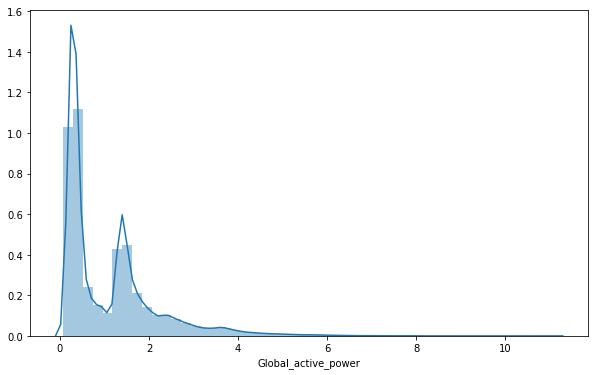

In [38]:
plt.figure(figsize=(10,6))
sns.distplot(data.Global_active_power);
print( 'Kurtosis of normal distribution: {}'.format(stats.kurtosis(data.Global_active_power)))
print( 'Skewness of normal distribution: {}'.format(stats.skew(data.Global_active_power)))

##First Time Series Plot

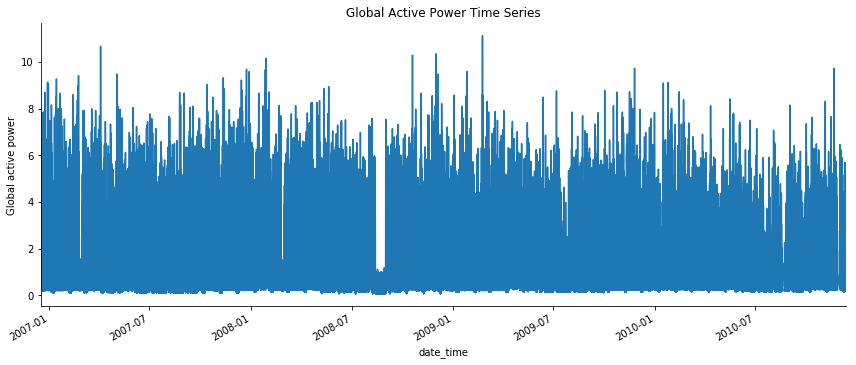

In [39]:
df_1=data.loc[:,["date_time","Global_active_power"]]
df_1.set_index("date_time",inplace=True)
df_1.plot(figsize=(12,5))
plt.ylabel('Global active power')
plt.legend().set_visible(False)
plt.tight_layout()
plt.title('Global Active Power Time Series')
sns.despine(top=True)
plt.show();

##Box Plot of Yearly vs. Quarterly Global Active Power

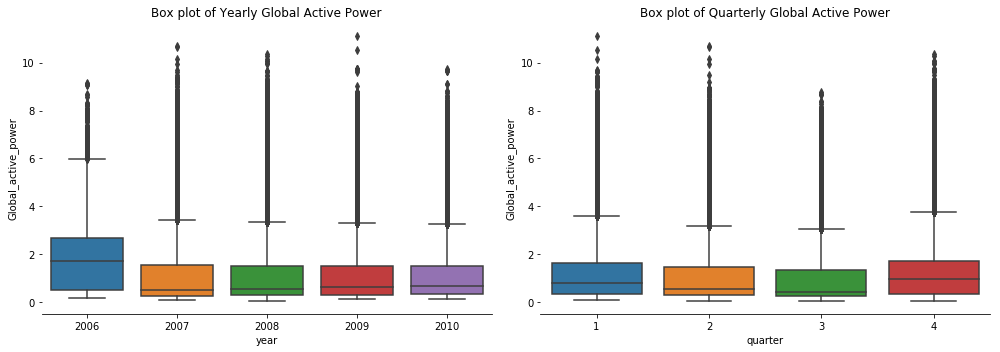

In [43]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.subplots_adjust(wspace=0.2)
sns.boxplot(x="year",y="Global_active_power",data=data)
plt.xlabel('year')
plt.title('Box plot of Yearly Global Active Power')
sns.despine(left=True)
plt.tight_layout()


plt.subplot(1,2,2)
sns.boxplot(x="quarter", y="Global_active_power", data=data)
plt.xlabel('quarter')
plt.title('Box plot of Quarterly Global Active Power')
sns.despine(left=True)
plt.tight_layout();

When we compare box plot side by side for each year, we notice that the median global active power in 2006 is much higher than the other years’. This is a little bit misleading. If you remember, we only have December data for 2006. While apparently December is the peak month for household electric power consumption.

This is consistent with the quarterly median global active power, it is higher in the 1st and 4th quarters (winter), and it is the lowest in the 3rd quarter (summer).

,count,mean,std,min,25%,50%,75%,max
Global_active_power,2049280.0,1.091615,1.057294,0.076,0.308,0.602,1.528,11.122


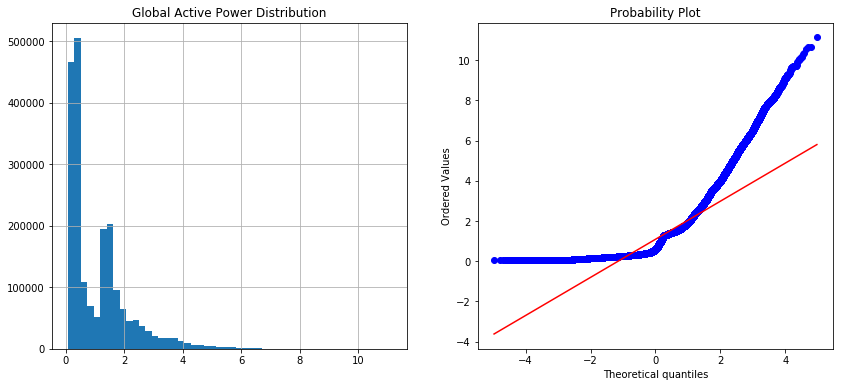

In [44]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
data['Global_active_power'].hist(bins=50)
plt.title('Global Active Power Distribution')

plt.subplot(1,2,2)
stats.probplot(data['Global_active_power'], plot=plt);
df_1.describe().T

Normal probability plot also shows the data is far from normally distributed.

##Average Global Active Power Resampled Over Day, Week, Month, Quarter and Year

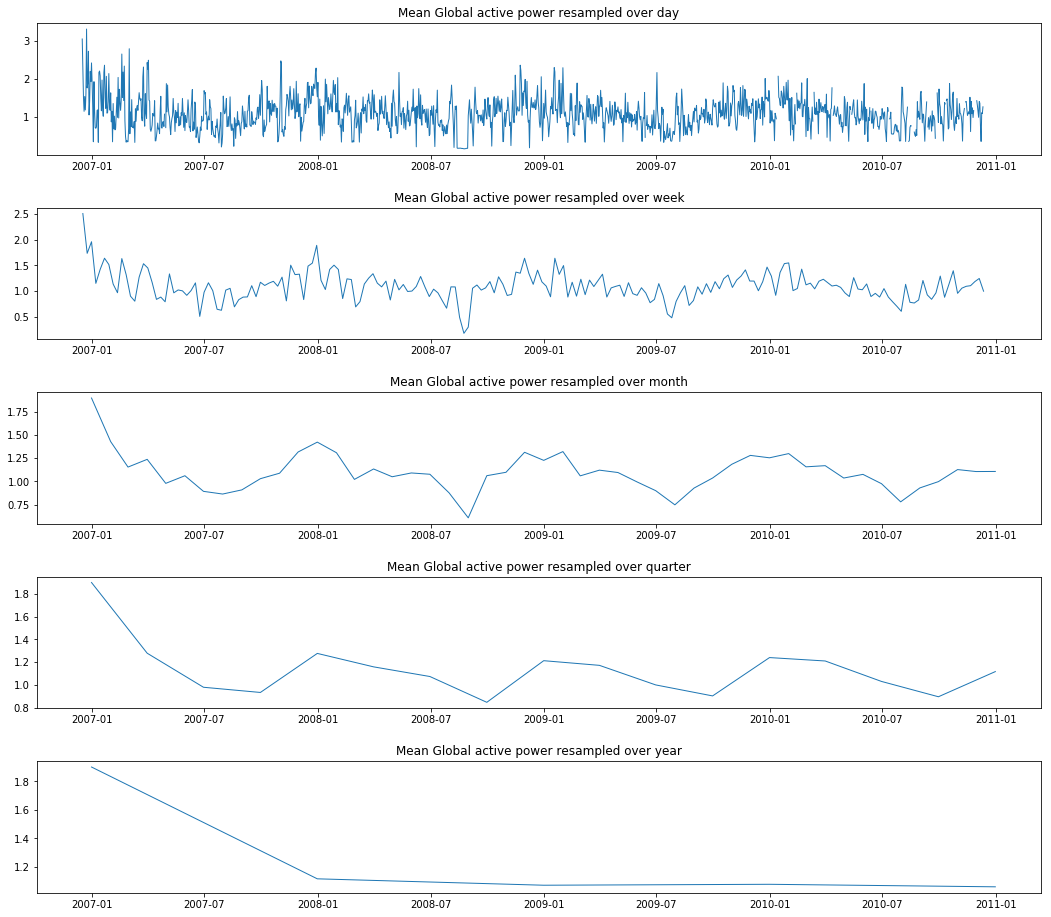

In [45]:
fig = plt.figure(figsize=(18,16))
fig.subplots_adjust(hspace=.4)
ax1 = fig.add_subplot(5,1,1)
ax1.plot(df_1['Global_active_power'].resample('D').mean(),linewidth=1)
ax1.set_title('Mean Global active power resampled over day')
ax1.tick_params(axis='both', which='major')

ax2 = fig.add_subplot(5,1,2, sharex=ax1)
ax2.plot(df_1['Global_active_power'].resample('W').mean(),linewidth=1)
ax2.set_title('Mean Global active power resampled over week')
ax2.tick_params(axis='both', which='major')

ax3 = fig.add_subplot(5,1,3, sharex=ax1)
ax3.plot(df_1['Global_active_power'].resample('M').mean(),linewidth=1)
ax3.set_title('Mean Global active power resampled over month')
ax3.tick_params(axis='both', which='major')

ax4  = fig.add_subplot(5,1,4, sharex=ax1)
ax4.plot(df_1['Global_active_power'].resample('Q').mean(),linewidth=1)
ax4.set_title('Mean Global active power resampled over quarter')
ax4.tick_params(axis='both', which='major')

ax5  = fig.add_subplot(5,1,5, sharex=ax1)
ax5.plot(df_1['Global_active_power'].resample('A').mean(),linewidth=1)
ax5.set_title('Mean Global active power resampled over year')
ax5.tick_params(axis='both', which='major');

In general, our time series does not have a upward or downward trend. The highest average power consumption seems to be prior to 2007, actually it was because we had only December data in 2007 and that month was a high consumption month. In another word, if we compare year by year, it has been steady.

##Plot Mean Global Active Power Grouped by Year, Quarter, Month and Day

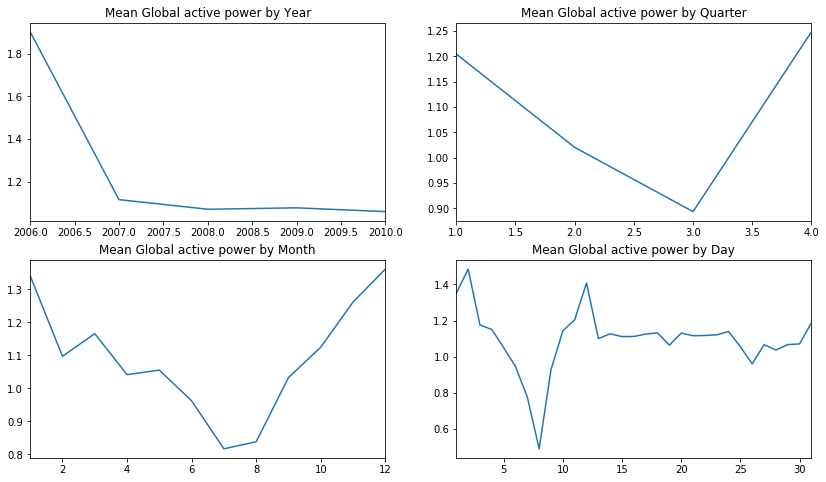

In [46]:
plt.figure(figsize=(14,8))
plt.subplot(2,2,1)
data.groupby('year').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Year')

plt.subplot(2,2,2)
data.groupby('quarter').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Quarter')

plt.subplot(2,2,3)
data.groupby('month').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Month')

plt.subplot(2,2,4)
data.groupby('day').Global_active_power.agg('mean').plot()
plt.xlabel('')
plt.title('Mean Global active power by Day');

The above plots confirmed our previous discoveries. By year, it was steady. By quarter, the lowest average power consumption was in the 3rd quarter. By month, the lowest average power consumption was in July and August. By day, the lowest average power consumption was around 8th of the month 

##Global Active Power by Years

This time, we remove 2006.

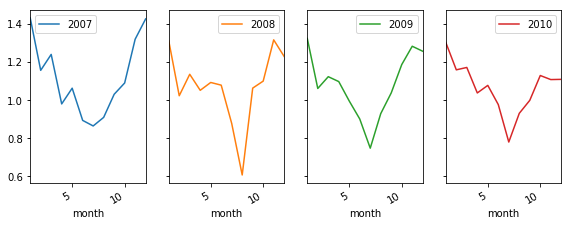

In [48]:
pd.pivot_table(data.loc[data['year'] != 2006], values = "Global_active_power", 
               columns = "year", index = "month").plot(subplots = True, figsize=(12, 12), layout=(3, 5), sharey=True);

The pattern is similar every year from 2007 to 2010.

##Global Active Power Consumption in Weekdays vs. Weekends

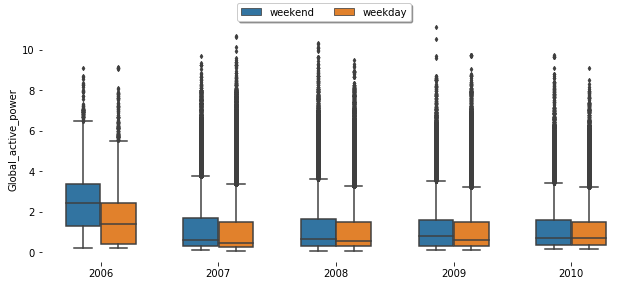

In [50]:
dic={0:"weekend",1:"weekday"}
data["Day"]=data.weekday.map(dic)
a=plt.figure(figsize=(9,4)) 
plt1=sns.boxplot('year','Global_active_power',hue='Day',width=0.6,fliersize=3,
                    data=data)                                                                                                                                                                                                                                                                                                                                                 
a.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=True, ncol=2)
sns.despine(left=True, bottom=True) 
plt.xlabel('')
plt.tight_layout()                                                                                                                  
plt.legend().set_visible(False);

The median global active power in weekdays seems to be lower than the weekends prior to 2010. In 2010, they were identical.

##Factor Plot of Global Active Power by Weekday vs. Weekend

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


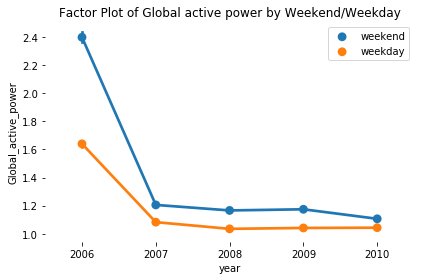

In [54]:
plt1=sns.factorplot('year','Global_active_power',hue='Day',
                    data=data, size=4, aspect=1.5, legend=False)                                                                                                                                                                                                                                                                                                                                             
plt.title('Factor Plot of Global active power by Weekend/Weekday')                                                             
plt.tight_layout()                                                                                                                  
sns.despine(left=True, bottom=True) 
plt.legend(loc='upper right');

Both weekdays and weekends follow the similar pattern over year.

In principle we do not need to check for stationarity nor correct for it when we are using an LSTM. However, if the data is stationary, it will help with better performance and make it easier for the neural network to learn.

##Stationarity
In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity.

Stationary series has constant mean and variance over time. Rolling average and the rolling standard deviation of time series do not change over time.

##Dickey-Fuller test

###Null Hypothesis (H0): 
It suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

###Alternate Hypothesis (H1): 
It suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

###p-value > 0.05: 
Accept the null hypothesis (H0), the data has a unit root and is non-stationary.

###p-value <= 0.05: 
Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


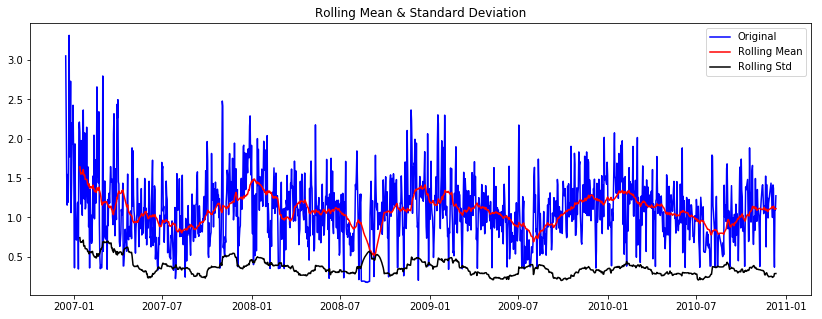

<Results of Dickey-Fuller Test>
Test Statistic                -8.327686e+00
p-value                        3.435135e-13
#Lags Used                     9.000000e+00
Number of Observations Used    1.423000e+03
Critical Value (1%)           -3.434954e+00
Critical Value (5%)           -2.863573e+00
Critical Value (10%)          -2.567852e+00
dtype: float64


In [55]:
df2=df_1.resample('D', how=np.mean)

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=30).mean()
    rolstd = timeseries.rolling(window=30).std()
    
    plt.figure(figsize=(14,5))
    sns.despine(left=True)
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    plt.legend(loc='best'); plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    print ('<Results of Dickey-Fuller Test>')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
test_stationarity(df2.Global_active_power.dropna())

From the above results, we will reject the null hypothesis H0, the data does not have a unit root and is stationary.

##LSTM

The task here will be to predict values for a time series given the history of 2 million minutes of a household’s power consumption. We are going to use a multi-layered LSTM recurrent neural network to predict the last value of a sequence of values.

If you want to reduce the computation time, and also get a quick result to test the model, you may want to resample the data over hour. I will keep it is in minute.

The following data pre-processing and feature engineering need to be done before construct the LSTM model.

    Create the dataset, ensure all data is float.
    Normalize the features.
    Split into training and test sets.
    Convert an array of values into a dataset matrix.
    Reshape into X=t and Y=t+1.
    Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [0]:
dataset=data.Global_active_power.values 
dataset=dataset.astype("float32")
dataset=np.reshape(dataset,(-1,1))
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)
train_size=int(len(dataset)*0.80)
test_size=len(dataset)-train_size

train,test=dataset[0:train_size,:],dataset[train_size:len(dataset),:]


def create_dataset(dataset, look_back=1):
  X, Y = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    X.append(a)
    Y.append(dataset[i + look_back, 0])
  return np.array(X), np.array(Y)


look_back = 30
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

##Model Architecture

    Define the LSTM with 100 neurons in the first hidden layer and 1 neuron in the output layer for predicting Global_active_power. The input shape will be 1 time step with 30 features.
    Dropout 20%.
    Use the MSE loss function and the efficient Adam version of stochastic gradient descent.
    The model will be fit for 20 training epochs with a batch size of 70.

In [61]:
model=Sequential()
model.add(LSTM(100,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer="adam")

history=model.fit(X_train,Y_train,epochs=20,batch_size=70,validation_data=(X_test,Y_test),callbacks=[EarlyStopping(monitor="val_loss",patience=10)],verbose=1,shuffle=False)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1639393 samples, validate on 409825 samples
Epoch 1/20
1639393/1639393 [==============================] - 121s 74us/step - loss: 7.7164e-04 - val_loss: 4.1191e-04
Epoch 2/20
1639393/1639393 [==============================] - 117s 71us/step - loss: 6.6436e-04 - val_loss: 4.4739e-04
Epoch 3/20
1639393/1639393 [==============================] - 116s 71us/step - loss: 6.5226e-04 - val_loss: 4.5534e-04
Epoch 4/20
1639393/1639393 [==============================] - 115s 70us/step - loss: 6.4612e-04 - val_loss: 4.5913e-04
Epoch 5/20
1639393/1639393 [==============================] - 116s 71us/step - loss: 6.4159e-04 - val_loss: 4.5153e-04
Epoch 6/20
1639393/1639393 [==============================] - 115s 70us/step - loss: 6.3900e-04 - val_loss: 4.4517e-0

##Make Predictions

In [62]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([Y_train])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 0.12811816292254957
Train Root Mean Squared Error: 0.272962507023531
Test Mean Absolute Error: 0.11522858564471875
Test Root Mean Squared Error: 0.2287106490512129


##Plot Model Loss

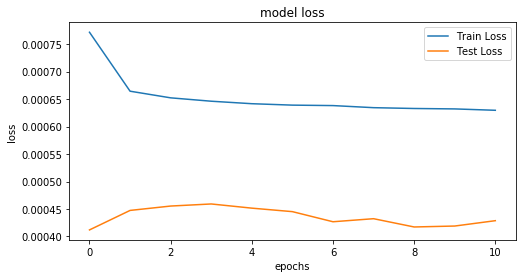

In [63]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

##Compare Actual vs. Prediction

For me, every time step is one minute. If you resampled the data over hour earlier, then every time step is one hour for you.

I will compare the actual and predictions for the last 200 minutes.

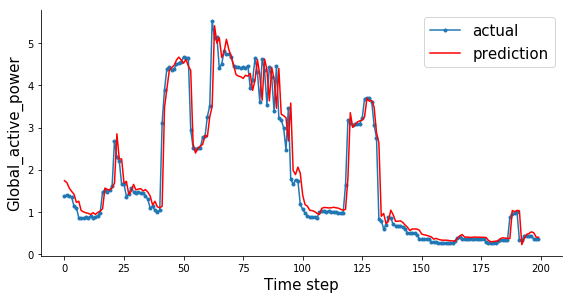

In [64]:
aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:200], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

LSTM is very good at prediction.

References :
1. [mutlivariate time series](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)
2. [Time series analysis](https://mlcourse.ai/)